                                 **Bayesian_inference_analysis**

In [16]:
#Import Libraries
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Load the Dataset
df = pd.read_csv("marketing_data.csv")
df.head()

,user_id,group,age,gender,device_type,traffic_source,region,time_on_site_sec,pages_visited,converted
0,1,pre,19,Male,Mobile,Email,East,421,11,0
1,2,post,23,Male,Mobile,Paid Ads,South,81,6,0
2,3,post,45,Female,Mobile,Organic,North,632,1,0
3,4,post,46,Male,Desktop,Organic,North,318,6,0
4,5,pre,43,Male,Mobile,Social Media,North,366,6,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           1500 non-null   int64 
 1   group             1500 non-null   object
 2   age               1500 non-null   int64 
 3   gender            1500 non-null   object
 4   device_type       1500 non-null   object
 5   traffic_source    1500 non-null   object
 6   region            1500 non-null   object
 7   time_on_site_sec  1500 non-null   int64 
 8   pages_visited     1500 non-null   int64 
 9   converted         1500 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 117.3+ KB


In [5]:
df.describe()

,user_id,age,time_on_site_sec,pages_visited,converted
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,38.616667,469.680000,7.358000,0.102667
std,433.157015,11.995401,253.128208,4.077203,0.303624
min,1.000000,18.000000,30.000000,1.000000,0.000000
25%,375.750000,28.000000,245.750000,4.000000,0.000000
50%,750.500000,38.000000,465.000000,7.000000,0.000000
75%,1125.250000,49.000000,694.250000,11.000000,0.000000
max,1500.000000,59.000000,899.000000,14.000000,1.000000


In [6]:
#Check Group Distribution
df["group"].value_counts()

,count
group,
post,759
pre,741


In [7]:
df["converted"].value_counts()

,count
converted,
0,1346
1,154


In [8]:
#Split Pre and Post Campaign Groups
pre = df[df["group"] == "pre"]["converted"].values
post = df[df["group"] == "post"]["converted"].values

n_pre = len(pre)
n_post = len(post)

conv_pre = pre.sum()
conv_post = post.sum()

n_pre, conv_pre, n_post, conv_post

(741, np.int64(55), 759, np.int64(99))

In [9]:
#Bayesian Model Definition
with pm.Model() as model:

    # Priors (conversion rates)
    theta_pre = pm.Beta("theta_pre", alpha=1, beta=1)
    theta_post = pm.Beta("theta_post", alpha=1, beta=1)

    # Likelihood
    y_pre = pm.Binomial("y_pre", n=n_pre, p=theta_pre, observed=conv_pre)
    y_post = pm.Binomial("y_post", n=n_post, p=theta_post, observed=conv_post)

    # Lift
    lift = pm.Deterministic("lift", theta_post - theta_pre)

    # Sampling
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )

Output()

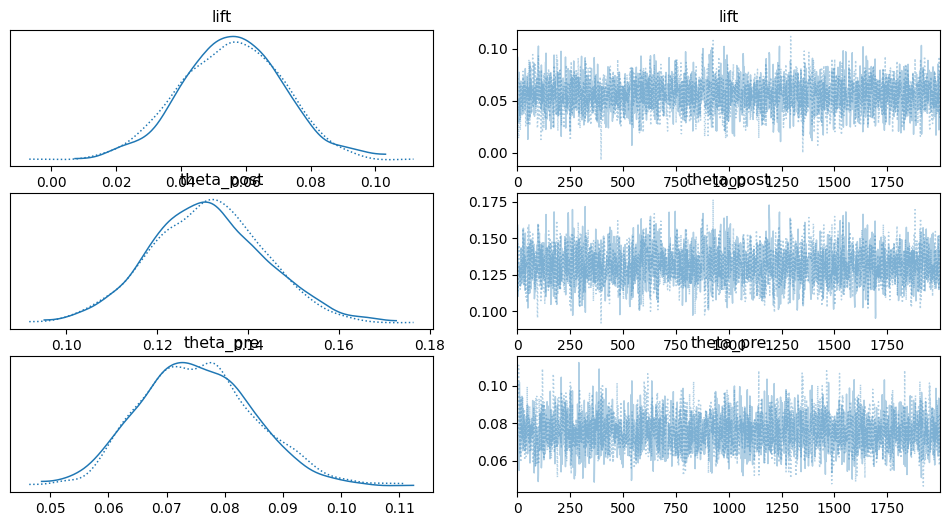

In [10]:
#Trace Plot (Convergence Check)
pm.plot_trace(trace)
plt.show()

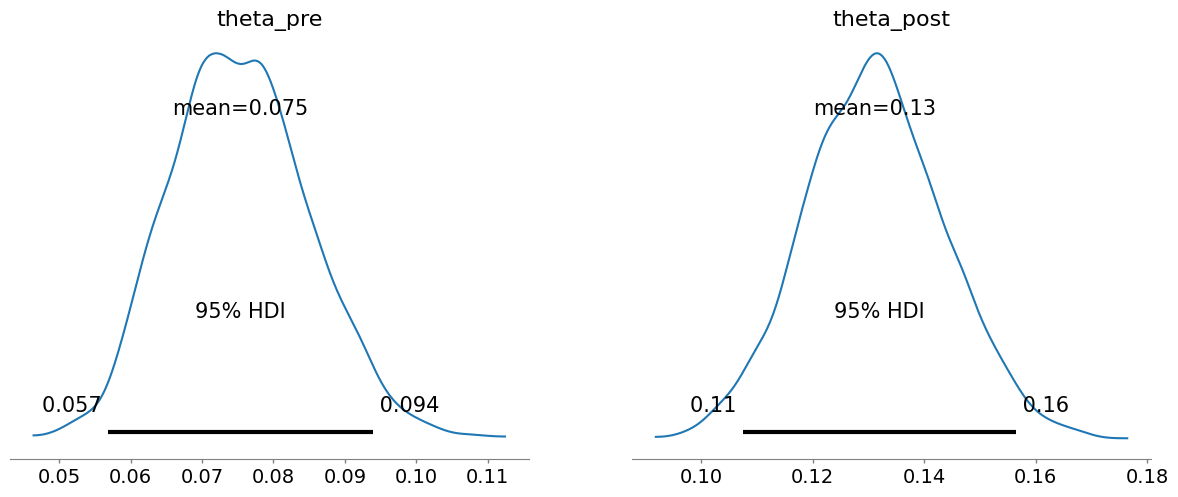

In [11]:
#Posterior Distributions (Conversion Rates)
pm.plot_posterior(
    trace,
    var_names=["theta_pre", "theta_post"],
    hdi_prob=0.95
)
plt.show()

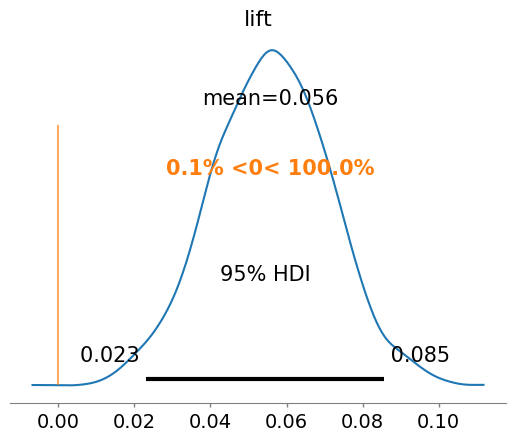

In [12]:
#Posterior Distribution of Lift
pm.plot_posterior(
    trace,
    var_names=["lift"],
    ref_val=0,
    hdi_prob=0.95
)
plt.show()

In [13]:
#Posterior Summary (Credible Intervals)
pm.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift,0.056,0.016,0.023,0.085,0.0,0.0,2476.0,2534.0,1.0
theta_post,0.131,0.013,0.107,0.156,0.0,0.0,2323.0,2074.0,1.0
theta_pre,0.075,0.010,0.057,0.094,0.0,0.0,2572.0,1853.0,1.0


In [14]:
#Probability That Campaign Improved Conversions
lift_samples = trace.posterior["lift"].values.flatten()
prob_campaign_success = (lift_samples > 0).mean()

prob_campaign_success

np.float64(0.9995)

In [15]:
#Frequentist Comparison
pre_rate = conv_pre / n_pre
post_rate = conv_post / n_post

pre_rate, post_rate, post_rate - pre_rate

(np.float64(0.07422402159244265),
 np.float64(0.13043478260869565),
 np.float64(0.056210761016253))

Business Insights



*  After the campaign, more people converted compared to before.item
*  There’s over a 95% chance that the campaign truly boosted performance.

*  The statistical range of possible outcomes does not include zero, meaning the effect is genuine.
*  Advice: Keep running the campaign or even expand it further.







Final Conclusion

Bayesian A/B testing shows with strong evidence that the campaign increased conversions. Unlike traditional methods, Bayesian analysis gives a direct probability of success, making decisions clearer and easier to act on.